## Convolutional-AutoEncoder-Pytorch-example

In [1]:
%load_ext lab_black

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pylab
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

%matplotlib inline

In [3]:
class AE_CNN(nn.Module):
    def __init__(self):
        super(AE_CNN, self).__init__()

        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation

        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))

        return x

### deviceの定義

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### データセットのインスタンス化

In [5]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.CIFAR10(
    root="data", train=True, download=True, transform=transform
)
test_data = datasets.CIFAR10(
    root="data", train=False, download=True, transform=transform
)

100.0%


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### データセットをデータローダに変換

In [6]:
# Create training and test dataloaders
num_workers = 1
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers
)

### データの可視化

In [7]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image


# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

/tmp/ipykernel_141/1524662445.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


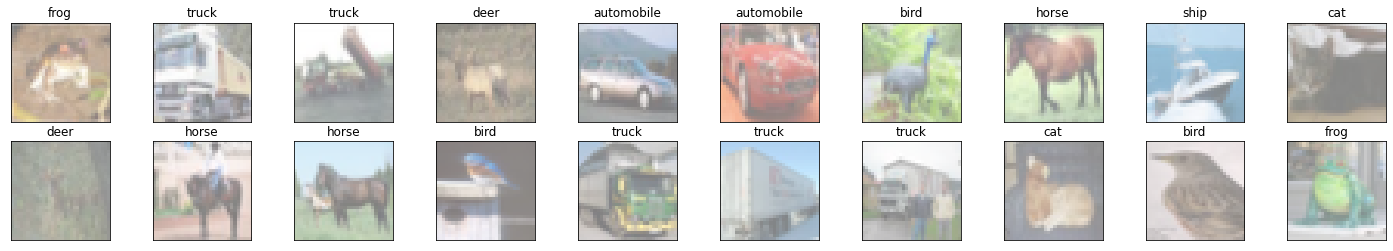

In [8]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

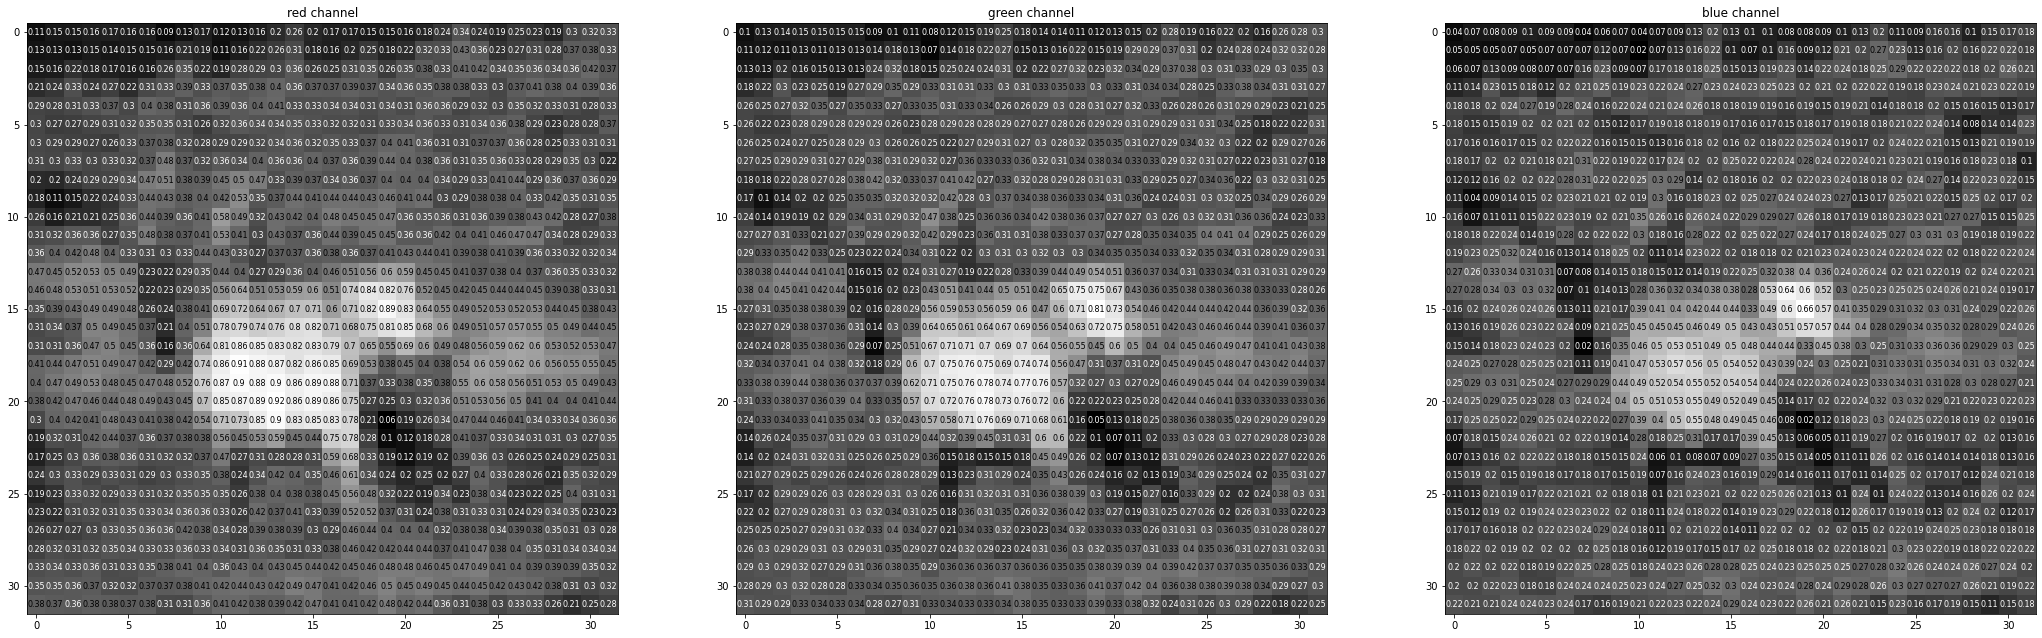

In [9]:
rgb_img = np.squeeze(images[3])
channels = ["red channel", "green channel", "blue channel"]

fig = plt.figure(figsize=(36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap="gray")
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            ax.annotate(
                str(val),
                xy=(y, x),
                horizontalalignment="center",
                verticalalignment="center",
                size=8,
                color="white" if img[x][y] < thresh else "black",
            )

### モデルのインスタンス化

In [10]:
model = AE_CNN().to(device)
print(model)

AE_CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [12]:
# specify loss function
criterion = nn.BCELoss()

# specify loss function
learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

### 学習率の変化を設定

In [13]:
def func_100(epoch):
    if epoch <= 100:
        return 1
    elif 100 < epoch:
        return -0.99 * (1e-2) * (epoch) + 1.99

In [14]:
scheduler = LambdaLR(optimizer, lr_lambda=func_100)

### モデルの学習

In [15]:
# number of epochs to train the model
n_epochs = 200

for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)

    # print avg training statistics
    train_loss = train_loss / len(train_loader)
    print("Epoch: {} \tTraining Loss: {:.6f}".format(epoch, train_loss))

/tmp/Python/python-3.9.6/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/tmp/Python/python-3.9.6/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 12.463387
Epoch: 2 	Training Loss: 11.714315
Epoch: 3 	Training Loss: 11.638463
Epoch: 4 	Training Loss: 11.606230
Epoch: 5 	Training Loss: 11.574443
Epoch: 6 	Training Loss: 11.525918
Epoch: 7 	Training Loss: 11.466352
Epoch: 8 	Training Loss: 11.437951
Epoch: 9 	Training Loss: 11.425698
Epoch: 10 	Training Loss: 11.418142
Epoch: 11 	Training Loss: 11.412183
Epoch: 12 	Training Loss: 11.407105
Epoch: 13 	Training Loss: 11.402600
Epoch: 14 	Training Loss: 11.397465
Epoch: 15 	Training Loss: 11.389487
Epoch: 16 	Training Loss: 11.383387
Epoch: 17 	Training Loss: 11.378738
Epoch: 18 	Training Loss: 11.374803
Epoch: 19 	Training Loss: 11.370872
Epoch: 20 	Training Loss: 11.366550
Epoch: 21 	Training Loss: 11.362482
Epoch: 22 	Training Loss: 11.358624
Epoch: 23 	Training Loss: 11.354908
Epoch: 24 	Training Loss: 11.352074
Epoch: 25 	Training Loss: 11.349851
Epoch: 26 	Training Loss: 11.347883
Epoch: 27 	Training Loss: 11.346046
Epoch: 28 	Training Loss: 11.344279
E

### 評価

/tmp/ipykernel_141/3656744825.py:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
/tmp/ipykernel_141/3656744825.py:36: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


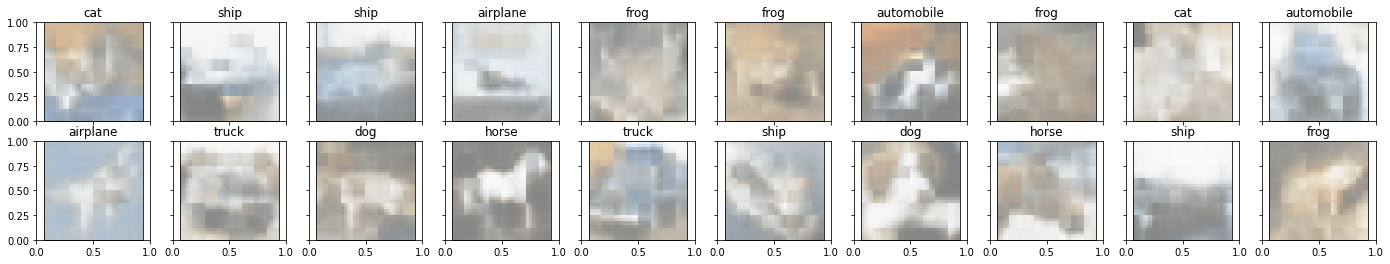

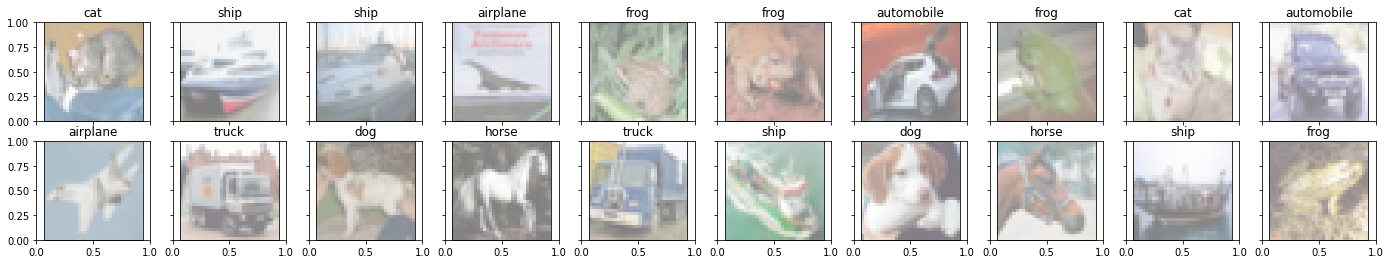

In [16]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()


# output is resized into a batch of iages
output = output.view(batch_size, 3, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# # plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))

# # input images on top row, reconstructions on bottom
# for images, row in zip([images, output], axes):
#     for img, ax in zip(images, row):
#         ax.imshow(np.squeeze(img))
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])